# Library

## Python packages 

In [1]:
import pandas as pd
import numpy as np
import regex as re
import rpy2
import os
import functools as fct
from collections import Counter
import pickle

/Users/tanya/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## R packages 

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(rlang)
library(ggplot2)
library(dplyr)
library(scales)
library(reshape2)
library(cowplot)
library(ape)
library(stringr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘ape’

The following object is masked from ‘package:dplyr’:

    where



In [4]:
%%R
# enrichment plots
library(enrichplot)
library(clusterProfiler)
library(msigdbr)


clusterProfiler v4.10.0  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141

Attaching package: ‘clusterProfiler’

The following object is masked from ‘package:stats’:

    filter



## Set path 

In [5]:
path_to_data = '/Users/tanya/Documents/OTT/Conflicts_ClinVar/data'
path_to_vcfs = '/Users/tanya/Documents/OTT/Conflicts_ClinVar/data/vcfs'   # path to initial ClinVar dfs
path_to_gatk = '/Users/tanya/Documents/tools/gatk-4.5.0.0/gatk'
path_to_tables = '/Users/tanya/Documents/OTT/Conflicts_ClinVar/tables'
path_to_plots = '/Users/tanya/Documents/OTT/Conflicts_ClinVar/plots'
path_to_temp = '/Users/tanya/Documents/OTT/Conflicts_ClinVar/temp'

## Load data

In [7]:
vep = pd.read_csv(f'{path_to_tables}/VEP_jn5mod.csv', sep=',')

/var/folders/sy/0s6mz48x25xdw7n08d30rp5w0000gn/T/ipykernel_57606/2072638769.py:1: DtypeWarning: Columns (0,25) have mixed types. Specify dtype option on import or set low_memory=False.
  vep = pd.read_csv(f'{path_to_tables}/VEP_jn5mod.csv', sep=',')


# How many genes do have conflicting variants? 

In [12]:
# genes have at least one P variant

pathogenic_genes_list = list(vep[vep['CLNSIG_MASK'] == 'P']['SYMBOL'].unique())
pathogenic_genes_list = [x for x in pathogenic_genes_list if str(x) != 'nan']
len(pathogenic_genes_list)

4702

In [29]:
# genes  with COI  and with at least ine P

coi_pgenes_list = vep[vep['CLNSIG_MASK'] == 'COI']['SYMBOL'].unique()

coi_pgenes_list = [x for x in coi_pgenes_list if x in pathogenic_genes_list]
coi_pgenes_list = [x for x in coi_pgenes_list if str(x) != 'nan']
len(coi_pgenes_list)

3627

In [14]:
coi_ids_list  = vep[vep['CLNSIG_MASK'] == 'COI']['ID'].unique()
len(coi_ids_list)

134238

In [15]:
non_coi_ids_list = vep[vep['CLNSIG_MASK'] != 'COI']['ID'].unique()
len(non_coi_ids_list)

2591000

# For how many genes is there a statistical enrichment of COI?  

Hypergeometric distribution: N = all ClinVar variants, K = all conflicts, n = number of ClinVar variants in gene X, k = number of conflicts in gene X.  

In [11]:
# count COI variants for gene

coi_genes = vep.loc[vep['CLNSIG_MASK'] == 'COI', ['SYMBOL']]
coi_genes_count = coi_genes.groupby(['SYMBOL']).size().reset_index().sort_values(by=[0], ascending=False)
coi_genes_count.columns = ['gene','n_coi_in_gene']
coi_genes_count.head(3)

,gene,n_coi_in_gene
461,BRCA2,5323
4192,TTN,3751
460,BRCA1,2988


In [12]:
# count non-coi variants in these genes

no_coi = vep.loc[~vep['ID'].isin(coi_ids_list)]
print(no_coi.shape)

(2120863, 26)


In [13]:
# count non-coi variants for each gene
no_coi_genes_count = no_coi.groupby(['SYMBOL']).size().reset_index().sort_values(by=[0], ascending=False)
no_coi_genes_count.columns = ['gene','n_non_coi_in_gene']

# collect data about coi and non-coi variants for gene
coi_genes_ea = coi_genes_count.merge(no_coi_genes_count, on=['gene'], how='left')

print(coi_genes_ea.shape)

# calculate other metrics
coi_genes_ea['n_var_in_gene'] = coi_genes_ea['n_coi_in_gene'] + coi_genes_ea['n_non_coi_in_gene']
coi_genes_ea['n_total_coi'] = 134238
coi_genes_ea['n_total_var'] = 2139697


coi_genes_ea.head(3)

(4462, 3)


,gene,n_coi_in_gene,n_non_coi_in_gene,n_var_in_gene,n_total_coi,n_total_var
0,BRCA2,5323,11663.0,16986.0,134238,2139697
1,TTN,3751,23141.0,26892.0,134238,2139697
2,BRCA1,2988,10260.0,13248.0,134238,2139697


In [14]:
%%R -i coi_genes_ea

# Enrichment

coi_genes_ea$hyper_pval <- with(coi_genes_ea, 
                                phyper(n_coi_in_gene - 1,   # k = number of conflicts in gene X
                                       n_total_coi,         # K = all conflicts
                                       n_total_var - n_total_coi, #  all ClinVar variants (N) - all COI (K)
                                       n_var_in_gene,       # n = number of ClinVar variants in gene X
                                       lower.tail = FALSE))

coi_genes_ea$hyper_padj <- p.adjust(coi_genes_ea$hyper_pval, method="fdr")


coi_genes_ea_flt <-coi_genes_ea %>% 
  filter(hyper_padj <= 0.05)%>% arrange(hyper_padj)

nrow(coi_genes_ea_flt)

[1] 390


In [16]:
# COI EA in genes with at least one P variant

vars_in_pgenes = vep.loc[vep['SYMBOL'].isin(pathogenic_genes_list)]

coi_in_pgenes = vars_in_pgenes.loc[vars_in_pgenes['ID'].isin(coi_ids_list)]
print(coi_in_pgenes.shape)

ncoi_in_pgenes = vars_in_pgenes.loc[~vars_in_pgenes['ID'].isin(coi_ids_list)]
print(ncoi_in_pgenes.shape)

(130806, 27)
(2163750, 27)


In [19]:
# number of coi in genes with at least one P
coi_in_pgenes_count = coi_in_pgenes.groupby(['SYMBOL']).size().reset_index().sort_values(by=[0], ascending=False)
coi_in_pgenes_count.columns = ['gene','n_coi_in_gene']
coi_in_pgenes_count.head(3)

,gene,n_coi_in_gene
376,BRCA2,5323
3426,TTN,3751
375,BRCA1,2988


In [20]:
# number of  non-coi in genes with at least one P

ncoi_in_pgenes_count = ncoi_in_pgenes.groupby(['SYMBOL']).size().reset_index().sort_values(by=[0], ascending=False)
ncoi_in_pgenes_count.columns = ['gene','n_non_coi_in_gene']

# collect data about coi and non-coi variants for gene
coi_pgenes_ea = coi_in_pgenes_count.merge(ncoi_in_pgenes_count, on=['gene'], how='left')

print(coi_pgenes_ea.shape)

# calculate other metrics
coi_pgenes_ea['n_var_in_gene'] = coi_pgenes_ea['n_coi_in_gene'] + coi_pgenes_ea['n_non_coi_in_gene']
coi_pgenes_ea['n_total_coi'] = 130806
coi_pgenes_ea['n_total_var'] = 2294556


coi_pgenes_ea.head(3)

(3627, 3)


,gene,n_coi_in_gene,n_non_coi_in_gene,n_var_in_gene,n_total_coi,n_total_var
0,BRCA2,5323,12836,18159,130806,2294556
1,TTN,3751,26989,30740,130806,2294556
2,BRCA1,2988,10855,13843,130806,2294556


In [21]:
%%R -i coi_pgenes_ea

# Enrichment

coi_pgenes_ea$hyper_pval <- with(coi_pgenes_ea, 
                                phyper(n_coi_in_gene - 1,   # k = number of conflicts in gene X
                                       n_total_coi,         # K = all conflicts
                                       n_total_var - n_total_coi, #  all ClinVar variants (N) - all COI (K)
                                       n_var_in_gene,       # n = number of ClinVar variants in gene X
                                       lower.tail = FALSE))

coi_pgenes_ea$hyper_padj <- p.adjust(coi_pgenes_ea$hyper_pval, method="fdr")


coi_pgenes_ea_flt <-coi_pgenes_ea %>% 
  filter(hyper_padj <= 0.05)%>% arrange(hyper_padj)

nrow(coi_pgenes_ea_flt)

[1] 292


In [22]:
%%R
head(coi_pgenes_ea_flt)
write.table(coi_pgenes_ea_flt, './temp/coi_pgenes_ea_flt.csv', sep='\t', quote=FALSE)
# features of enriched genes


# Enrichment Analysis

In [23]:
%%R

coi_pgenes_ea <- read.csv('./temp/coi_pgenes_ea_flt.csv', sep='\t')
head(coi_pgenes_ea)

     gene n_coi_in_gene n_non_coi_in_gene n_var_in_gene n_total_coi n_total_var
0   BRCA2          5323             12836         18159      130806     2294556
1     TTN          3751             26989         30740      130806     2294556
2   BRCA1          2988             10855         13843      130806     2294556
4    MSH2          1108              5832          6940      130806     2294556
10   APOB           691              2738          3429      130806     2294556
16 COL6A3           601              2683          3284      130806     2294556
      hyper_pval    hyper_padj
0   0.000000e+00  0.000000e+00
1   0.000000e+00  0.000000e+00
2   0.000000e+00  0.000000e+00
4  5.306237e-207 4.811430e-204
10 6.080808e-184 4.411018e-181
16 6.085897e-140 3.678925e-137


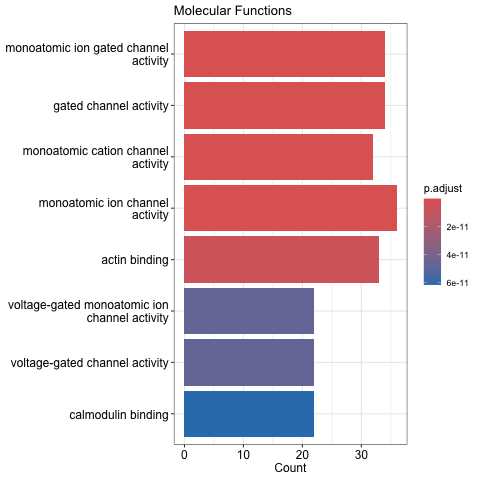

In [26]:
%%R
genes_plot <- enrichGO(gene = unique(coi_pgenes_ea$gene),
                       OrgDb = "org.Hs.eg.db",
                       keyType = "SYMBOL",
                       #ont           = "BP",
                       #ont           = "CC",
                       #ont           = "MF",
                       pAdjustMethod = "fdr",
                       #pvalueCutoff  = 0.01,
                       qvalueCutoff  = 0.05)
#goplot(genes_plot)
#barplot(genes_plot) + ggtitle("Biological Processes")
#barplot(genes_plot) + ggtitle("Cellular Components")
#barplot(genes_plot) + ggtitle("Molecular Functions")
#write.table(genes_plot,"Genes_GO_BP.csv",quote = F,sep = "\t",row.names = F)

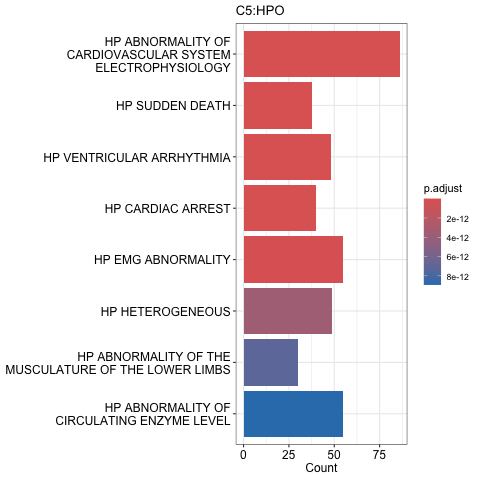

In [27]:
%%R

#C5-HPO
m_df <- msigdbr(species = "Homo sapiens")
head(m_df) %>% as.data.frame
m_t2g <- msigdbr(species = "Homo sapiens", category = "C5", subcategory = "HPO") %>% 
  dplyr::select(gs_name,gene_symbol)
em <- enricher(unique(coi_pgenes_ea$gene), TERM2GENE=m_t2g)
#write.table(em,"Enrich_MSGDIB_C5_HPO_SAB.csv",quote = F,sep = "\t",row.names = F)

barplot(em) + ggtitle("C5:HPO")

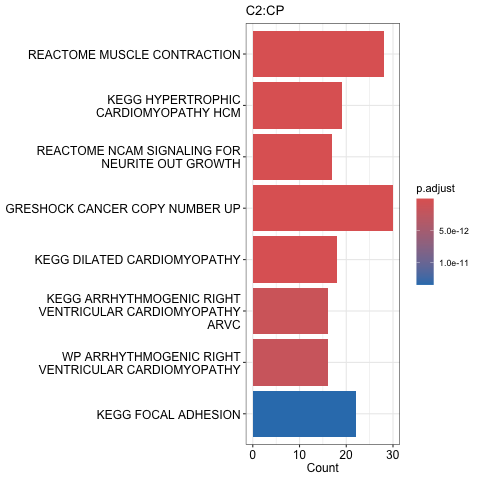

In [28]:
%%R

#C2
m_df <- msigdbr(species = "Homo sapiens")
head(m_df) %>% as.data.frame
m_t2g <- msigdbr(species = "Homo sapiens", category = "C2") %>% 
  dplyr::select(gs_name,gene_symbol)
em <- enricher(unique(coi_pgenes_ea$gene), TERM2GENE=m_t2g)

#write.table(em,"Enrich_MSGDIB_C2_SAB.csv",quote = F,sep = "\t",row.names = F)

barplot(em) + ggtitle("C2:CP")
#heatplot(em, showCategory = 15, foldChange = NULL)+ geom_point() + scale_colour_gradient(low = "blue", high = "red")